<a href="https://colab.research.google.com/github/mohamed-mkh15/Search-and-Sample-Return/blob/main/Search_and_Sample_Return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search and Sample Return

## The Perception Step


### Reading in Color Images

In order to navigate autonomously through the environment, we will use 320x160 pixel camera images to determine where it is possible to drive. In general, this can be a very complicated task, but in this case, it's simplified a bit.

![image](https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg)

Throughout the environment, the sand on the ground is very light in color and everything else in the environment is dark. All we have to do to determine where you can drive is to figure out where the areas of lighter color are. As an example of how to do this, we'll look at the above image using Python. The image could be downloaded here: https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg

--2023-08-16 11:30:55--  https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.216.48, 52.219.193.72, 52.219.121.80, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.216.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10914 (11K) [image/jpeg]
Saving to: ‘sample.jpg.1’

sample.jpg.1        100%[===================>]  10.66K  --.-KB/s    in 0s      

2023-08-16 11:30:55 (59.8 MB/s) - ‘sample.jpg.1’ saved [10914/10914]



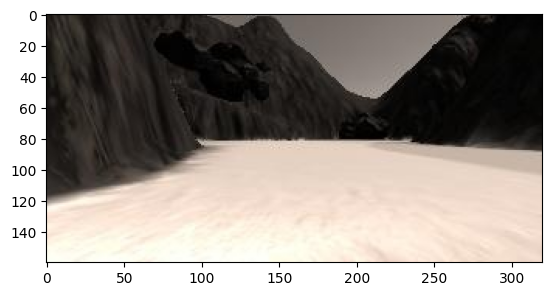

In [4]:
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# %matplotlib inline

# Define the filename, read and plot the image
!wget "https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg"
filename = 'sample.jpg'
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

Exploreing what it's size and datatype are, as well as the minimum and maximum values in the array

In [5]:
# Import the "numpy" package for working with arrays
import numpy as np
print(image.dtype, image.shape, np.min(image), np.max(image))
# uint8 (160, 320, 3) 0 255

uint8 (160, 320, 3) 0 255


Size of the array is (160, 320, 3) meaning the image size is 160 pixels in the y-direction (height), 320 pixels in the x-direction (width) and it has 3 layers or "color channels".

The three color channels of the image are red, green and blue or "RGB" for short. The combination of intensity values across the three channels determines what color we see in the image.

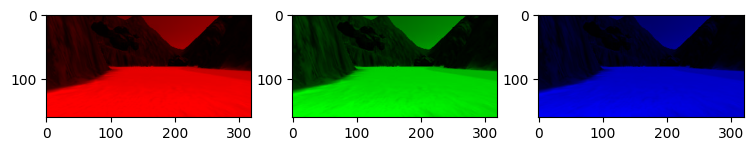

In [6]:
# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!
red_channel = np.copy(image)
# Note: here instead of extracting individual channels from the image
# I'll keep all 3 color channels in each case but set the ones I'm not interested
# in to zero.
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels
fig = plt.figure(figsize=(9,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
plt.show()

### Color Thresholding

We can see now that, while the mountains are relatively dark (low intensity values) in all three color channels, both the ground and the sky are brighter (higher intensity) in the red, green and blue channels. However, in all cases it looks like the ground is a bit brighter than the sky, such that it should be possible to identify pixels associated with the ground using a simple color threshold.

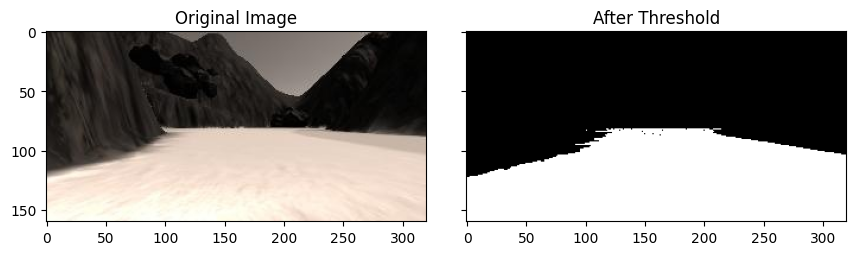

In [7]:
# Define color sealection criteria
###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 180
green_threshold = 180
blue_threshold = 180
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    # Create an empty array the same size in x and y as the image
    # but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    # Apply the thresholds for RGB and assign 1's
    # where threshold was exceeded
    up_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Now update the value of color_select with making the indecies refered
    # to by up_thresh have a value of 1
    color_select[up_thresh]=1
    # Return the single-channel binary image
    return color_select

# pixels above the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

# Display the original image and binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=12)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('After Threshold', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.show() # Uncomment if running on your local machine

## Perspective Transform


Perspective transforms involve some complicated geometry but here we'll use the OpenCV functions cv2.getPerspectiveTransform() and cv2.warpPerspective() to do the heavy lifting (for more on this and other geometric transforms you can do with OpenCV, check out this page: https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html).

So, we'll want to perform the following steps:

- Define 4 source points, in this case, the 4 corners of a grid cell in the image above.
- Define 4 destination points (must be listed in the same order as source points!).
- Use cv2.getPerspectiveTransform() to get M, the transform matrix.
- Use cv2.warpPerspective() to apply M and warp your image to a top-down view.

First, we need to select four points in our "source" image and map them to four points in our "destination" image, which will be the top-down view. An example image can be found here: https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/example_grid1.jpg.

--2023-08-16 11:30:26--  https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/example_grid1.jpg
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.0, 52.219.194.152, 52.219.193.112, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7370 (7.2K) [image/jpeg]
Saving to: ‘example_grid1.jpg.1’

example_grid1.jpg.1 100%[===================>]   7.20K  --.-KB/s    in 0s      

2023-08-16 11:30:26 (256 MB/s) - ‘example_grid1.jpg.1’ saved [7370/7370]



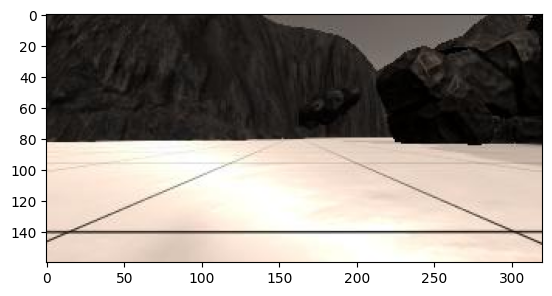

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# This enables the interactive matplotlib window
#%matplotlib notebook

!wget "https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/example_grid1.jpg"
image = mpimg.imread('example_grid1.jpg')
plt.imshow(image)
plt.show()

### Choosing source points


To get interactive figures, we will have to switch matplotlib backend .. will use interactive IPython backend like ipyml or widget instead of notebook.


Note1: I think that %matplotlib notebook injects some kind of javascript that kills something inside jupyter lab.

Note2: once we’ve run %matplotlib notebook, we can’t later switch to %matplotlib widget (because the two will use different event loops). we need to only ever use one or the other while the kernel is running.

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

In [9]:
# %matplotlib ipympl
%matplotlib widget
# %matplotlib notebook

Now will create a fucntion to print clicked pixels. Try to pick the four corners of the square.  

to read more about events: https://matplotlib.org/stable/users/explain/event_handling.html


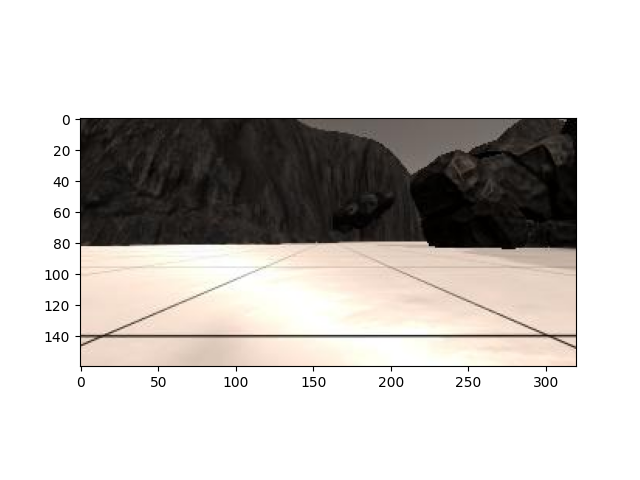

15.629032258064512 140.5322580645161
118.20967741935483 96.01612903225805
199.5 96.01612903225805
302.0806451612903 140.5322580645161


In [10]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

ax.imshow(image)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

### Choosing destination points


With the source points chosen, all that's left is choosing destination points. In this case, it makes sense to choose a square set of points so that square meters in the grid are represented by square areas in the destination image.

((( If you face problems with the figures from now on, restart runtime and rerun the code without the previous "choosing source points" part. Continue working with matplotlib)))

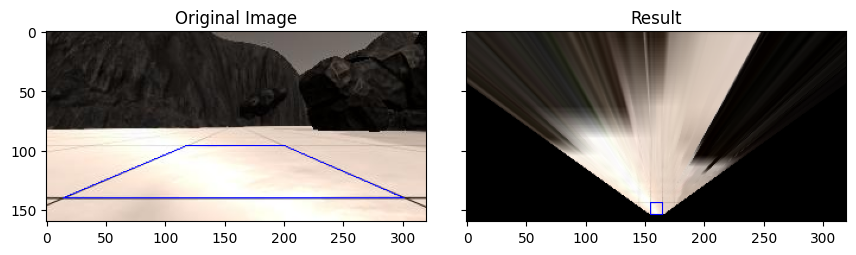

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

image2 = mpimg.imread('example_grid1.jpg')

def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5
# Set a bottom offset to account for the fact that the bottom of the image
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image2.shape[1]/2 - dst_size, image2.shape[0] - bottom_offset],
                  [image2.shape[1]/2 + dst_size, image2.shape[0] - bottom_offset],
                  [image2.shape[1]/2 + dst_size, image2.shape[0] - 2*dst_size - bottom_offset],
                  [image2.shape[1]/2 - dst_size, image2.shape[0] - 2*dst_size - bottom_offset],
                  ])


warped2 = perspect_transform(image2, source, destination)
# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image2, np.int32([source]), True, (0, 0, 255), 1)
cv2.polylines(warped2, np.int32([destination]), True, (0, 0, 255), 1)
# Display the original image and binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
f.tight_layout()
ax1.imshow(image2)
ax1.set_title('Original Image', fontsize=12)

ax2.imshow(warped2, cmap='gray')
ax2.set_title('Result', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() # Uncomment if running on your local machine

## Warp, Threshold, & Map

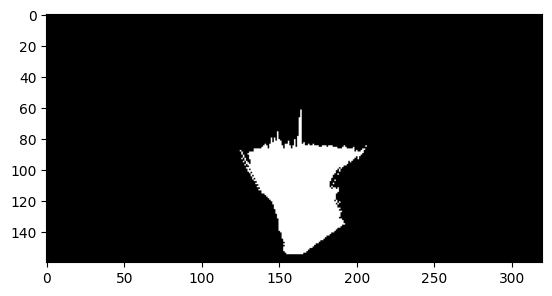

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Uncomment the next line for use in a Jupyter notebook
#%matplotlib inline
import numpy as np
import cv2

# Read in the same sample image as before
image3 = mpimg.imread('sample.jpg')

# Assume you have already defined perspect_transform() and color_thresh()
warped3 = perspect_transform(image3, source, destination)
colorsel3 = color_thresh(warped3, rgb_thresh=(160, 160, 160))

# Plot the result
plt.imshow(colorsel3, cmap='gray')
plt.show()

We are now looking down on the rover's world from above and white indicates where we have identified navigable terrain in the view from the rover camera. The position of the rover camera in this image would be at roughly (x, y) = (160, 160).

To get the pixel positions in image space:



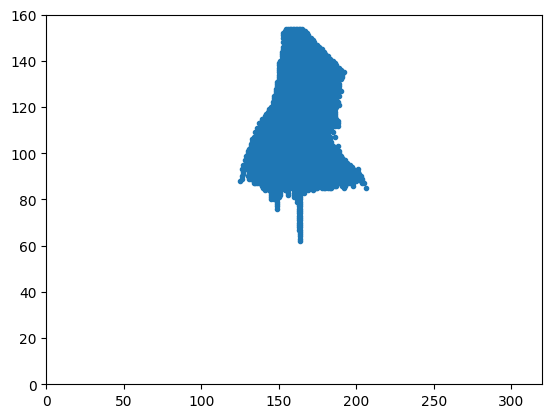

In [9]:
ypos, xpos = colorsel3.nonzero()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0, 160)
plt.show()

Whoa! But it's upside-down! This is actually the same plot / image as before, we're just looking at it with the origin (0, 0) in the lower left, rather than the upper left, and the y-axis reversed.


Now we have x and y pixel positions in image space of the navigable terrain and all we need to do is convert it to rover-centric coordinates. However, we would also like to swap the x and y axes such that they're consistent with the world coordinate system that we'll eventually be mapping to. The image below shows both the rover-centric coordinate system we will define, and the world coordinate system, which is the reference frame that is fixed with respect to the world and that we will later be mapping to.
![image](https://video.udacity-data.com/topher/2017/May/5921f4f6_screen-shot-2017-05-21-at-1.12.06-pm/screen-shot-2017-05-21-at-1.12.06-pm.png)

Now, we will try to write a function to take in a binary image, extract the x and y positions in image coordinates and then return x and y in rover coordinates.

Text(0.5, 1.0, 'Rover-Centric Map')

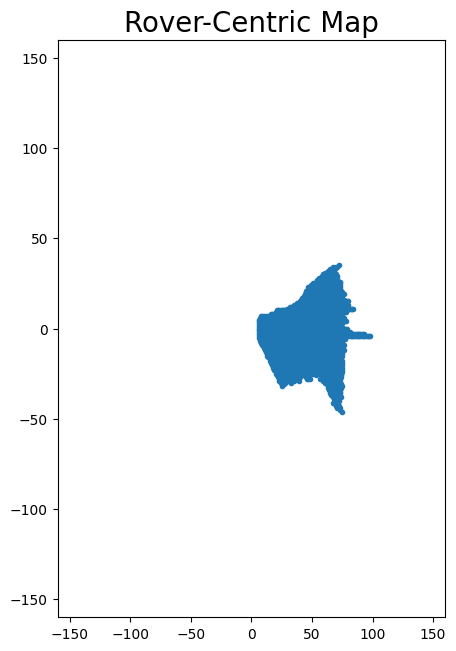

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the sample image
image = mpimg.imread('sample.jpg')

# Perform warping and color thresholding
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(float)
    return x_pixel, y_pixel

x_pixel, y_pixel = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(x_pixel, y_pixel, '.')
plt.ylim(-160, 160)
plt.xlim(-160, 160)
plt.title('Rover-Centric Map', fontsize=20)
#plt.show() # Uncomment if running on your local machine

## Map to World Coordinates


Our goal now is to write code that will allow us to use the rover's position, orientation and camera image to map its environment and compare against this ground truth map!
![image](https://video.udacity-data.com/topher/2017/May/590a9746_screen-shot-2017-05-03-at-7.51.28-pm/screen-shot-2017-05-03-at-7.51.28-pm.png)

### Rotation and Translation

Now that we have generated a map of navigable terrain in rover-centric coordinates, the next step is to map those points to world coordinates. To do this, we'll use a rotation followed by a translation. The rotation is required to account for the fact that when the camera takes a picture, the rover can be pointing in any arbitrary direction, given by it's yaw angle. The translation is to account for the fact that the rover may be located at any position in the world when it takes a picture. So, it's a 2 step process:

- Rotate the rover-centric coordinates so that the x and y axes are parallel to the axes in world space.
- Translate the rotated positions by the x and y position values given by the rover's location (position vector) in the world.

![image](https://video.udacity-data.com/topher/2017/May/5921f819_screen-shot-2017-05-21-at-1.26.20-pm/screen-shot-2017-05-21-at-1.26.20-pm.png)

Will apply the following rotation
![image](https://video.udacity-data.com/topher/2017/May/59068084_screen-shot-2017-04-30-at-5.24.52-pm/screen-shot-2017-04-30-at-5.24.52-pm.png)

Xpos = [67.68389496] Ypos = [176.26318855] Yaw = [143.49360644]


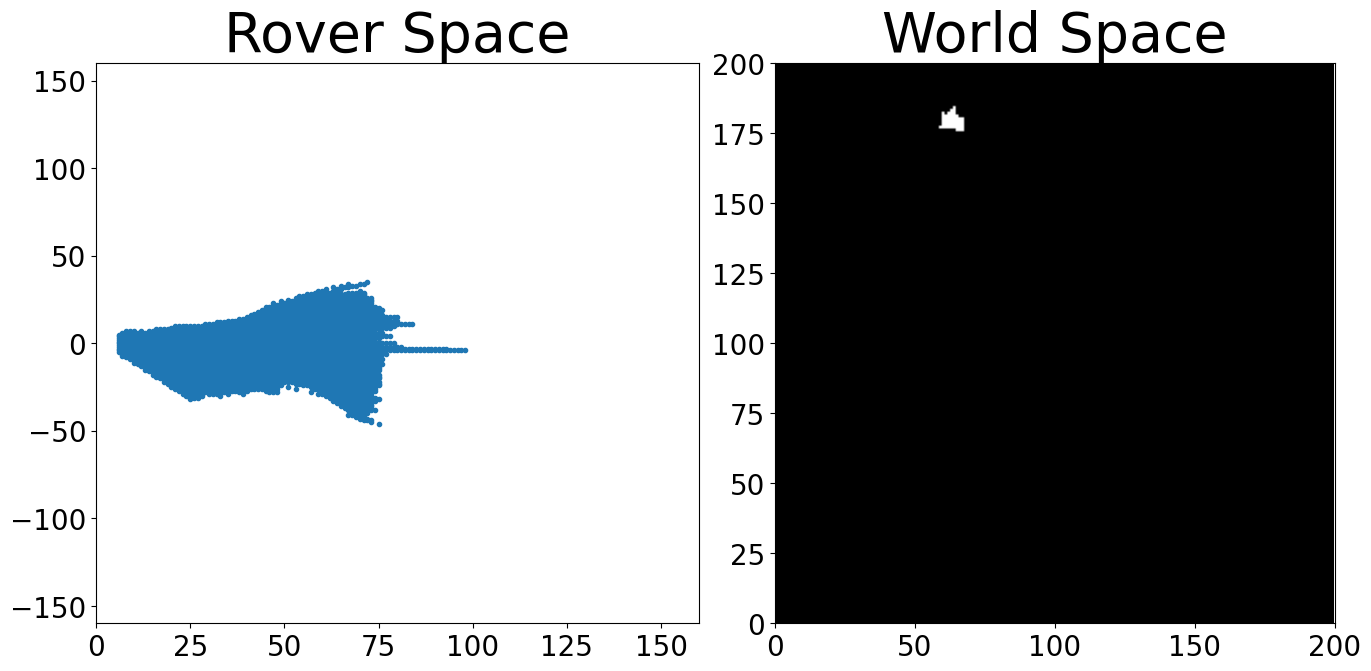

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the sample image
image = mpimg.imread('sample.jpg')

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: we need to convert this to radians before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position,
# multiple run of the code will result in different outputs each time.

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))

    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Perform warping and color thresholding
##
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5
# Set a bottom offset to account for the fact that the bottom of the image
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos,
                                rover_ypos, rover_yaw,
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
#plt.show() # Uncomment if running on your local machine

## Navigation step

We now have the mapping piece and realistically, that means the hard work is done! With each new image we receive from the rover's camera, we will have the opportunity to make a decision about sending commands like throttle, brake and steering. But how to decide what values to send for these commands?

Let's start with steering. For that, we need to calculate **steering angle**. we have already calculated the x and y positions of navigable terrain pixels in rover space and now we'd like to decide which direction to steer the rover. One simple way to decide is to choose the direction with the clearest path or in other words, the most navigable terrain pixels!

To do this you we first convert your (x, y) pixel positions to polar coordinates, where each pixel position is represented by its distance from the origin and angle counterclockwise from the positive x-direction.

In [12]:
import numpy as np

# Define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

Now let's try an example!

--2023-08-16 12:03:02--  https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/angle_example.jpg
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.88, 52.219.113.152, 52.219.192.56, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7176 (7.0K) [image/jpeg]
Saving to: ‘angle_example.jpg’

angle_example.jpg   100%[===================>]   7.01K  --.-KB/s    in 0s      

2023-08-16 12:03:02 (122 MB/s) - ‘angle_example.jpg’ saved [7176/7176]



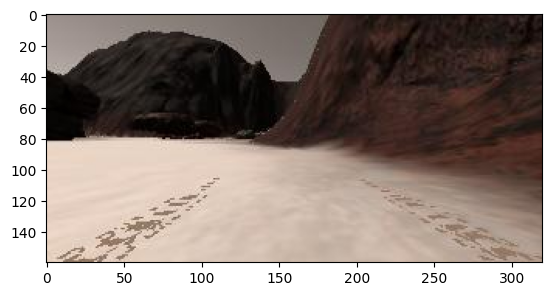

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# This enables the interactive matplotlib window
#%matplotlib notebook

!wget "https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/angle_example.jpg"
image = mpimg.imread('angle_example.jpg')
plt.imshow(image)
plt.show()

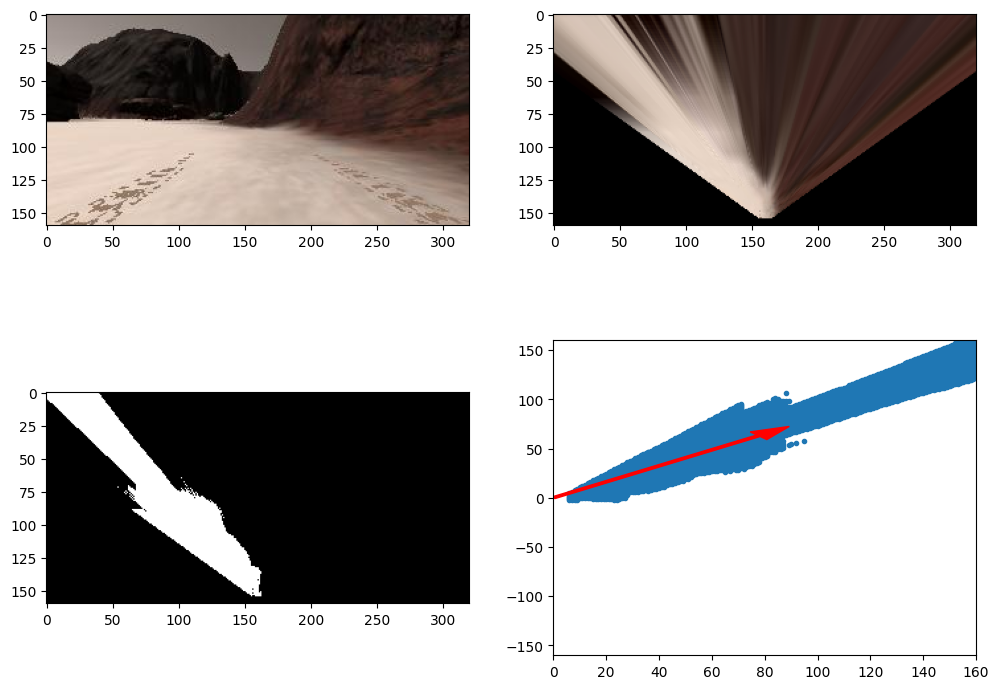

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Uncomment the next line for use in a Jupyter notebook
#%matplotlib inline
import numpy as np
# from extra_functions import perspect_transform, color_thresh, rover_coords

image = mpimg.imread('angle_example.jpg')
warped = perspect_transform(image, source, destination) # Perform perspective transform
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

Given the approximate field of view of the camera, the average values for angle that we get will vary between about +/- pi/4
radians. The input for steering angles we can send to the rover is in degrees over the range -15 (to the right) to +15 (to the left), so the last step is to choose a conversion between our average angle and the steering angle we want to send to the rover. The simplest thing to do would be to convert to degrees and clip to the range +/- 15 like this:

In [19]:
avg_angle_degrees = avg_angle * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)
print("Steering angle: ", steering, "degrees")

Steering angle:  15.0 degrees


## Now for the Decision state

![image](https://video.udacity-data.com/topher/2017/April/58f2b074_screen-shot-2017-04-15-at-4.44.30-pm/screen-shot-2017-04-15-at-4.44.30-pm.png)

There are essentially an infinite number of considerations we could come up with to base our decisions on, but really we could think of any combination of them as a decision tree, like the one above.

We could think of this tree as a very basic form of artificial intelligence, where we have simply hardcoded a range of possible scenarios and a decision associated with each.

We'll define a Python class called RoverState() that will allow we to track the changing state of the rover.

In [22]:
# Define RoverState() class to retain rover state parameters
class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = None # Current camera image
        self.pos = None # Current position (x, y)
        self.yaw = None # Current yaw angle
        self.pitch = None # Current pitch angle
        self.roll = None # Current roll angle
        self.vel = None # Current velocity
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = None # Angles of navigable terrain pixels
        self.nav_dists = None # Distances of navigable terrain pixels
        self.ground_truth = None # = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.max_vel = 2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float)
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float)
        self.samples_pos = None # To store the actual sample positions
        self.samples_found = 0 # To count the number of samples found
        self.near_sample = False # Set to True if within reach of a rock sample
        self.pick_up = False # Set to True to trigger rock pickup


We can then create an instance of this class:



In [ ]:
Rover = RoverState()

Now we can update Rover with each new set of telemetry values, for example:

In [ ]:
# Rover.vel = new_velocity_from_telemetry
# Rover.yaw = new_yaw_from_telemetry

We can create a decision tree like the one pictured above using conditional statements to decide what to do next based on current telemetry and / or our analysis, for example:



In [ ]:
# if Rover.vel >= Rover.max_vel:
#     Rover.throttle = 0
# else:
#     Rover.throttle = Rover.throttle_set